# Radar Plots

# Setup

In [1]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from mplsoccer import PyPizza, FontManager

In [2]:
notebook_directory = os.getcwd()
course_directory = notebook_directory.rsplit("/Notebooks")[0]
os.chdir(course_directory)

# Data

In [3]:
df = pd.DataFrame()

for i in range(13):
    with open(f"data/wyscout/events_England_{i+1}.json") as file:
        data = json.load(file)    
    df = pd.concat([df, pd.DataFrame(data)])

df

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175
...,...,...,...,...,...,...,...,...,...,...,...,...
43145,5,Ball out of the field,[],0,"[{'y': 32, 'x': 0}, {'y': 100, 'x': 100}]",2500098,Interruption,1623,2H,2796.732525,50,251596409
43146,3,Corner,"[{'id': 302}, {'id': 801}, {'id': 1801}]",70965,"[{'y': 100, 'x': 100}, {'y': 47, 'x': 88}]",2500098,Free Kick,1633,2H,2829.821084,30,251596232
43147,1,Air duel,"[{'id': 701}, {'id': 1802}]",7919,"[{'y': 53, 'x': 12}, {'y': 50, 'x': 14}]",2500098,Duel,1623,2H,2831.211419,10,251596410
43148,1,Air duel,"[{'id': 703}, {'id': 1801}]",8005,"[{'y': 47, 'x': 88}, {'y': 50, 'x': 86}]",2500098,Duel,1633,2H,2832.434399,10,251596234


# Calculate xG
This uses the method used in lesson 2.

In [4]:
def calculate_xG(df, npxG):
    shots_df = df[df['subEventName'] == "Shot"].copy()
    shots_df["X"] = shots_df["positions"].apply(lambda cell: (100-cell[0]["x"]) * 105/100)
    shots_df["Y"] = shots_df["positions"].apply(lambda cell: cell[0]["y"] * 68/100)
    shots_df["C"] = shots_df["positions"].apply(lambda cell: abs(100-cell[0]["y"] - 50) * 68/100)

    shots_df["Distance"] = np.sqrt(shots_df["X"] ** 2 + shots_df["C"] ** 2)
    shots_df["Angle"] = np.where(np.arctan(7.32 * shots_df["X"] / (shots_df["X"] ** 2 + shots_df["C"] ** 2 - (7.32/2)**2)) > 0,  np.arctan(7.32 * shots_df["X"] /(shots_df["X"]**2 + shots_df["C"]**2 - (7.32/2)**2)), np.arctan(7.32 * shots_df["X"] /(shots_df["X"]**2 + shots_df["C"]**2 - (7.32/2)**2)) + np.pi)
    shots_df["Goal"] = shots_df["tags"].apply(lambda x: 1 if {"id":101} in x else 0).astype(object)

    headers = shots_df.loc[shots_df.apply(lambda x : {"id":403} in x.tags, axis=1)].copy()
    non_headers = shots_df.drop(headers.index)

    headers_model = smf.glm(formula="Goal ~ Distance + Angle", data=headers, family=sm.families.Binomial()).fit()
    non_headers_model = smf.glm(formula="Goal ~ Distance + Angle", data=non_headers, family=sm.families.Binomial()).fit()

    b_head = headers_model.params

    xG = 1/(1+np.exp(b_head.iloc[0]+b_head.iloc[1]*headers['Distance'] + b_head.iloc[2]*headers['Angle']))
    headers["xG"] = xG

    b_non_head = non_headers_model.params
    xG = 1/(1+np.exp(b_non_head.iloc[0]+b_non_head.iloc[1]*non_headers['Distance'] + b_non_head.iloc[2]*non_headers['Angle']))
    non_headers["xG"] = xG

    if npxG == False:
        penalties = df.loc[df["subEventName"] == "Penalty"]
        penalties["xG"] = 0.76
        all_shots_xg = pd.concat([non_headers[["playerId", "xG"]], headers[["playerId", "xG"]], penalties[["playerId", "xG"]]])
        xG_sum = all_shots_xg.groupby(["playerId"])["xG"].sum().sort_values(ascending = False).reset_index()
    else:
        all_shots_xg = pd.concat([non_headers[["playerId", "xG"]], headers[["playerId", "xG"]]])
        all_shots_xg.rename(columns={"xG" : "npxG"}, inplace=True)
        xG_sum = all_shots_xg.groupby(["playerId"])["npxG"].sum().sort_values(ascending = False).reset_index()
    
    return xG_sum

npxg = calculate_xG(df, npxG=True)
npxg.head(10)

,playerId,npxG
0,8717,21.839987
1,120353,16.885663
2,11066,14.046331
3,7905,12.840350
4,8325,12.167112
5,340386,10.213279
6,377071,10.200437
7,25413,10.139241
8,3324,10.127311
9,14703,9.221099


# Passes into the final 1/3 & Receptions in the final third
- Reception: Player who makes the next action is the reciever.

In [5]:
def FinalThird(df):
    df = df.copy()
    
    df["nextPlayerId"] = df["playerId"].shift(-1)

    passes = df.loc[df["eventName"] == "Pass"].copy()
    passes["x"] = passes.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
    passes["y"] = passes.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
    passes["end_x"] = passes.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
    passes["end_y"] = passes.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)

    accurate_passes = passes.loc[passes.apply(lambda x : {"id":1801} in x.tags, axis=1)]
    final_third_passes = accurate_passes.loc[accurate_passes["end_x"] > 2*105/3]

    final_third_pass_player = final_third_passes.groupby(["playerId"])["end_x"].count().reset_index()
    final_third_pass_player.rename(columns={"end_x":"final_third_passes"}, inplace=True)

    reception_final_third_player = final_third_passes.groupby(["nextPlayerId"])["end_x"].count().reset_index()
    reception_final_third_player.rename(columns={"end_x":"final_third_receptions", "nextPlayerId":"playerId"}, inplace=True)

    final_third = final_third_pass_player.merge(reception_final_third_player, how="outer", on="playerId")
    return final_third

final_third = FinalThird(df)
final_third.head(10)

,playerId,final_third_passes,final_third_receptions
0,36.0,186.0,83.0
1,38.0,62.0,66.0
2,48.0,392.0,188.0
3,54.0,818.0,800.0
4,56.0,27.0,29.0
5,74.0,115.0,41.0
6,93.0,265.0,365.0
7,107.0,233.0,299.0
8,116.0,286.0,215.0
9,120.0,10.0,21.0


# Ground and Air Duels Won

In [6]:
def wonDuels(df):
    air_duels = df.loc[df["subEventName"] == "Air duel"]
    won_air_duels = air_duels.loc[air_duels.apply(lambda x:{'id':703} in x.tags, axis=1)]
    won_air_duels_player = won_air_duels.groupby("playerId")["eventId"].count().reset_index()
    won_air_duels_player.rename(columns = {"eventId" : "air_duels_won"}, inplace=True)

    ground_duels = df.loc[df["subEventName"] == "Ground attacking duel"]
    won_ground_duels = ground_duels.loc[ground_duels.apply(lambda x: {"id" : 703} in x.tags, axis=1)]
    won_ground_duels_player = won_ground_duels.groupby("playerId")["eventId"].count().reset_index()
    won_ground_duels_player.rename(columns = {"eventId" : "ground_duels_won"}, inplace=True)

    duels_won = won_ground_duels_player.merge(won_air_duels_player, how="outer", on="playerId")
    return duels_won

duels = wonDuels(df)
duels.head(10)

,playerId,ground_duels_won,air_duels_won
0,0,2244.0,1061.0
1,36,13.0,23.0
2,38,7.0,11.0
3,48,50.0,137.0
4,54,102.0,15.0
5,56,7.0,3.0
6,74,14.0,48.0
7,93,141.0,42.0
8,107,49.0,58.0
9,116,76.0,21.0


# Calculating Smart Passes
- A smart pass is a pass which breaks the defensive line.

In [7]:
def smartPasses(df):
    smart_passes = df.loc[df["subEventName"] == "Smart pass"]
    smart_passes_made = smart_passes.loc[smart_passes.apply(lambda x:{"id":1801} in x.tags, axis=1)]

    smart_passes_player = smart_passes_made.groupby("playerId")["eventId"].count().reset_index()
    smart_passes_player.rename(columns={"eventId":"smart_passes"}, inplace=True)

    return smart_passes_player

smart_passes = smartPasses(df)
smart_passes.head(5)

,playerId,smart_passes
0,36,1
1,38,1
2,48,3
3,54,42
4,56,1


# Non-Penalty Goals, Assists & Key Passes

In [8]:
def GoalsAssistsKeyPasses(df):
    shots_df = df[df['subEventName'] == "Shot"].copy()
    goals = shots_df.loc[shots_df.apply(lambda x:{"id":101} in x.tags, axis=1)]

    passes = df.loc[df["eventName"] == "Pass"]
    assists = passes.loc[passes.apply(lambda x : {"id":301} in x.tags, axis=1)]
    key_passes = passes.loc[passes.apply(lambda x : {"id":302} in x.tags, axis=1)]

    goals_player = goals.groupby("playerId")["eventId"].count().reset_index()
    goals_player.rename(columns = {"eventId":"goals"}, inplace=True)

    assists_player = assists.groupby("playerId")["eventId"].count().reset_index()
    assists_player.rename(columns = {"eventId":"assists"}, inplace=True)

    key_passes_player = key_passes.groupby("playerId")["eventId"].count().reset_index()
    key_passes_player.rename(columns = {"eventId":"key_passes"}, inplace=True)

    data = goals_player.merge(assists_player, how="outer", on="playerId").merge(key_passes_player, how="outer", on="playerId")
    return data

goals_assits_key_passes = GoalsAssistsKeyPasses(df)
goals_assits_key_passes.head(5)

,playerId,goals,assists,key_passes
0,54,10.0,5.0,25.0
1,74,1.0,NaN,1.0
2,93,2.0,5.0,14.0
3,116,1.0,1.0,3.0
4,120,1.0,1.0,NaN


# Minutes Played

In [9]:
minutes_played_df = pd.read_json("data/wyscout/minutes_played_per_game_England.json")
minutes_played_df.head()

,playerId,shortName,matchId,teamId,teamName,player_in_min,player_out_min,minutesPlayed,red_card
0,9206,C. Wood,2500089,1646,Burnley FC,0,61,61,0
1,9127,S. Vokes,2500089,1646,Burnley FC,61,95,34,0
2,93,J. Gu\u00f0munds\u00adson,2500089,1646,Burnley FC,0,80,80,0
3,9179,N. Wells,2500089,1646,Burnley FC,80,95,15,0
4,10108,K. Long,2500089,1646,Burnley FC,0,95,95,0


In [10]:
player_minutes = minutes_played_df.groupby("playerId")["minutesPlayed"].sum().reset_index()
player_minutes

,playerId,minutesPlayed
0,36,1238
1,38,382
2,48,3343
3,54,3348
4,56,266
...,...,...
510,448708,21
511,450826,35
512,486252,649
513,531655,28


# Summary
- Best to do this for players with >400 minutes played in order to get an accurate & reliable measure of what they can actually do.

In [11]:
players = df["playerId"].unique()
summary = pd.DataFrame(players, columns = ["playerId"])
summary = summary.merge(npxg, how = "left", on = ["playerId"]).merge(final_third, how = "left", on = ["playerId"]).merge(duels, how = "left", on = ["playerId"]).merge(smart_passes, how = "left", on = ["playerId"]).merge(goals_assits_key_passes, how = "left", on = ["playerId"])

summary = player_minutes.merge(summary, how = "left", on = ["playerId"])
summary = summary.fillna(0)
summary

,playerId,minutesPlayed,npxG,final_third_passes,final_third_receptions,ground_duels_won,air_duels_won,smart_passes,goals,assists,key_passes
0,36,1238,0.599599,186.0,83.0,13.0,23.0,1.0,0.0,0.0,2.0
1,38,382,0.141448,62.0,66.0,7.0,11.0,1.0,0.0,0.0,1.0
2,48,3343,1.233519,392.0,188.0,50.0,137.0,3.0,0.0,0.0,3.0
3,54,3348,6.179483,818.0,800.0,102.0,15.0,42.0,10.0,5.0,25.0
4,56,266,0.025593,27.0,29.0,7.0,3.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
510,448708,21,0.078115,3.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0
511,450826,35,0.109182,7.0,8.0,9.0,0.0,1.0,0.0,0.0,0.0
512,486252,649,0.000000,62.0,62.0,24.0,10.0,0.0,0.0,0.0,2.0
513,531655,28,0.000000,2.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0


In [12]:
summary_for_players_with_over_400_minutes = summary.loc[summary["minutesPlayed"] > 400].reset_index(drop=True)
summary_for_players_with_over_400_minutes

,playerId,minutesPlayed,npxG,final_third_passes,final_third_receptions,ground_duels_won,air_duels_won,smart_passes,goals,assists,key_passes
0,36,1238,0.599599,186.0,83.0,13.0,23.0,1.0,0.0,0.0,2.0
1,48,3343,1.233519,392.0,188.0,50.0,137.0,3.0,0.0,0.0,3.0
2,54,3348,6.179483,818.0,800.0,102.0,15.0,42.0,10.0,5.0,25.0
3,74,1514,0.472176,115.0,41.0,14.0,48.0,4.0,1.0,0.0,1.0
4,93,2942,3.112902,265.0,365.0,141.0,42.0,7.0,2.0,5.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...
392,397178,1904,4.800650,200.0,337.0,119.0,17.0,14.0,7.0,4.0,9.0
393,419784,405,0.033548,32.0,17.0,6.0,4.0,0.0,0.0,1.0,0.0
394,434159,561,1.122661,52.0,32.0,10.0,11.0,0.0,1.0,0.0,1.0
395,447812,499,0.013105,26.0,46.0,14.0,8.0,0.0,0.0,0.0,0.0


# Forwards

In [13]:
players_df = pd.read_json("data/wyscout/players.json")
forwards = players_df.loc[players_df.apply(lambda x : x.role["name"] == "Forward", axis=1)].copy()
forwards.rename(columns={"wyId" : "playerId"}, inplace=True)
to_merge = forwards[["playerId", "shortName"]]
forwards_summary = summary_for_players_with_over_400_minutes.merge(to_merge, how="inner", on="playerId")
forwards_summary

,playerId,minutesPlayed,npxG,final_third_passes,final_third_receptions,ground_duels_won,air_duels_won,smart_passes,goals,assists,key_passes,shortName
0,471,756,1.768601,39.0,69.0,37.0,48.0,4.0,2.0,0.0,1.0,W. Bony
1,3324,2143,10.127311,199.0,340.0,170.0,48.0,9.0,11.0,4.0,6.0,\u00c1lvaro Morata
2,3326,618,0.753910,43.0,81.0,33.0,0.0,3.0,1.0,1.0,3.0,Jes\u00e9 Rodr\u00edguez
3,3327,1775,5.840758,133.0,175.0,50.0,134.0,3.0,4.0,1.0,4.0,Joselu
4,3348,441,0.672588,49.0,69.0,31.0,0.0,4.0,1.0,0.0,1.0,Deulofeu
...,...,...,...,...,...,...,...,...,...,...,...,...
71,293687,1985,5.394631,127.0,279.0,75.0,148.0,2.0,4.0,4.0,4.0,D. Calvert-Lewin
72,340386,1729,10.213279,204.0,293.0,57.0,20.0,13.0,13.0,2.0,6.0,Gabriel Jesus
73,343951,1813,6.437222,76.0,161.0,93.0,52.0,6.0,5.0,1.0,3.0,T. Abraham
74,377071,2963,10.200437,253.0,470.0,244.0,130.0,11.0,5.0,4.0,5.0,Richarlison


# Statistics per 90 Minutes

In [14]:
forwards_summary_per_90 = pd.DataFrame()
forwards_summary_per_90["shortName"] = forwards_summary["shortName"]
for col in forwards_summary.columns[2:-1]:
    forwards_summary_per_90[f"{col}_per90"] = forwards_summary[col] * 90 / forwards_summary["minutesPlayed"]
forwards_summary_per_90 

,shortName,npxG_per90,final_third_passes_per90,final_third_receptions_per90,ground_duels_won_per90,air_duels_won_per90,smart_passes_per90,goals_per90,assists_per90,key_passes_per90
0,W. Bony,0.210548,4.642857,8.214286,4.404762,5.714286,0.476190,0.238095,0.000000,0.119048
1,\u00c1lvaro Morata,0.425319,8.357443,14.279048,7.139524,2.015866,0.377975,0.461969,0.167989,0.251983
2,Jes\u00e9 Rodr\u00edguez,0.109793,6.262136,11.796117,4.805825,0.000000,0.436893,0.145631,0.145631,0.436893
3,Joselu,0.296151,6.743662,8.873239,2.535211,6.794366,0.152113,0.202817,0.050704,0.202817
4,Deulofeu,0.137263,10.000000,14.081633,6.326531,0.000000,0.816327,0.204082,0.000000,0.204082
...,...,...,...,...,...,...,...,...,...,...
71,D. Calvert-Lewin,0.244593,5.758186,12.649874,3.400504,6.710327,0.090680,0.181360,0.181360,0.181360
72,Gabriel Jesus,0.531634,10.618855,15.251591,2.967033,1.041064,0.676692,0.676692,0.104106,0.312319
73,T. Abraham,0.319553,3.772752,7.992278,4.616657,2.581357,0.297849,0.248207,0.049641,0.148924
74,Richarlison,0.309834,7.684779,14.276072,7.411407,3.948701,0.334121,0.151873,0.121498,0.151873


In [15]:
forwards_summary_per_90.sort_values("npxG_per90", ascending=False).head(10)

,shortName,npxG_per90,final_third_passes_per90,final_third_receptions_per90,ground_duels_won_per90,air_duels_won_per90,smart_passes_per90,goals_per90,assists_per90,key_passes_per90
23,H. Kane,0.614058,7.591378,12.567948,5.370197,1.743205,0.449859,0.759138,0.056232,0.253046
64,O. Niasse,0.546917,7.066437,14.132873,5.280414,3.028473,0.388266,0.621225,0.077653,0.232959
18,S. Ag\u00fcero,0.537311,12.232581,18.503435,6.624141,0.706575,0.574092,0.750736,0.264966,0.706575
72,Gabriel Jesus,0.531634,10.618855,15.251591,2.967033,1.041064,0.676692,0.676692,0.104106,0.312319
26,C. Austin,0.513348,5.356177,9.576195,2.110009,2.921551,0.081154,0.486925,0.000000,0.081154
61,Mohamed Salah,0.507416,12.681135,18.631052,5.979967,0.300501,0.751252,0.931553,0.210351,0.330551
54,O. Giroud,0.485607,9.387008,18.032937,2.552608,5.187557,0.329369,0.576395,0.082342,0.494053
70,D. Solanke,0.484089,10.850077,16.970634,4.312210,3.060278,0.556414,0.139104,0.278207,0.556414
34,R. Sterling,0.468732,17.552836,26.929922,7.174638,0.300334,0.567297,0.567297,0.333704,0.634038
53,P. Aubameyang,0.454182,7.868852,12.295082,2.622951,0.737705,0.081967,0.737705,0.327869,0.327869


# Percentiles
- Often it will useful to look at the stats of players in terms of percentiles.

In [33]:
salah = forwards_summary_per_90.loc[forwards_summary_per_90["shortName"] == "Mohamed Salah"]
cols = ['npxG_per90', "goals_per90", "assists_per90", "key_passes_per90", "smart_passes_per90", "final_third_passes_per90", "final_third_receptions_per90", "ground_duels_won_per90", "air_duels_won_per90"]
salah = salah[cols]
salah

,npxG_per90,goals_per90,assists_per90,key_passes_per90,smart_passes_per90,final_third_passes_per90,final_third_receptions_per90,ground_duels_won_per90,air_duels_won_per90
61,0.507416,0.931553,0.210351,0.330551,0.751252,12.681135,18.631052,5.979967,0.300501


In [27]:
values = round(salah, 2)
values

,npxG_per90,goals_per90,assists_per90,key_passes_per90,smart_passes_per90,final_third_passes_per90,final_third_receptions_per90,ground_duels_won_per90,air_duels_won_per90
61,0.51,0.93,0.21,0.33,0.75,12.68,18.63,5.98,0.3


In [45]:
percentiles = [int(stats.percentileofscore(forwards_summary_per_90[col], salah[col].iloc[0])) for col in cols]
percentiles

[93, 100, 90, 67, 89, 86, 90, 69, 13]

# Radar Chart - per 90 Minutes

In [36]:
names = ["non-penalty Expected Goals", "non-penalty Goals", "Assists", "Key Passes", "Smart Passes", "Passes Ending in Final Third", "Passes Received in Final Third", "Offensive Ground Duels Won", "Air Duels Won"]
slice_colors = ["blue"] * 2 + ["green"] * 5 + ["red"] * 2
text_colors = ["white"] * 9

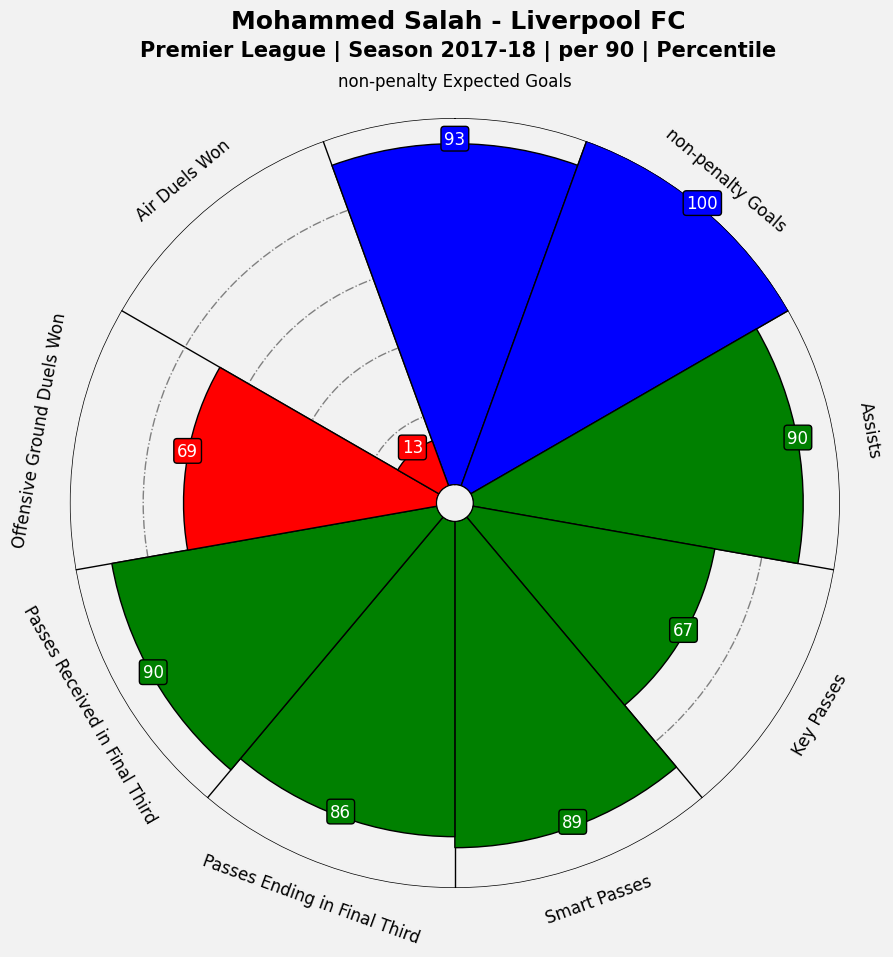

In [65]:
baker = PyPizza(params=names, straight_line_color="#000000", straight_line_lw=1, last_circle_lw=1, other_circle_lw=1, other_circle_ls="-.")
fig, ax = baker.make_pizza(
    percentiles
    , figsize=(15,10)
    , param_location=110
    , slice_colors=slice_colors
    , value_colors=text_colors
    , value_bck_colors=slice_colors
    , kwargs_slices=dict(facecolor="cornflowerblue", edgecolor="#000000", zorder=2, linewidth=1)
    , kwargs_params=dict(color="#000000", fontsize=12, va="center")
    , kwargs_values=dict(color="#000000", fontsize=12, zorder=3, bbox=dict(edgecolor="#000000", facecolor="cornflowerblue", boxstyle="round,pad=0.2", lw=1))    
)

fig.text(0.515, 0.97, "Mohammed Salah - Liverpool FC", size=18, ha="center", fontdict={"weight" : "bold"}, color="#000000")
fig.text(0.515, 0.942, "Premier League | Season 2017-18 | per 90 | Percentile", size=15, ha="center", fontdict={"weight" : "bold"}, color="#000000")
plt.show()

# Radar Chart - adjusted for Possession

In [68]:
possesion_dict = {}
for i, row in minutes_played_df.iterrows():
    player_id, team_id, match_id = row["playerId"], row["teamId"], row["matchId"]

    if not str(player_id) in possesion_dict.keys():
        possesion_dict[str(player_id)] = {"team_passes" : 0, "all_passes" : 0}
    
    min_in = row["player_in_min"] * 60
    min_out = row["player_out_min"] * 60

    match_df = df.loc[df["matchId"] == match_id].copy()
    match_df.loc[match_df["matchPeriod"] == "2H", 'eventSec'] = match_df.loc[match_df["matchPeriod"] == "2H", 'eventSec'] + match_df.loc[match_df["matchPeriod"] == "1H"]["eventSec"].iloc[-1]
    
    player_in_match_df = match_df.loc[match_df["eventSec"] > min_in].loc[match_df["eventSec"] <= min_out]

    all_passes = player_in_match_df.loc[player_in_match_df["eventName"].isin(["Pass", "Duel"])]

    if len(all_passes) > 0:
        no_contact = all_passes.loc[all_passes["subEventName"].isin(["Air duel", "Ground defending duel","Ground loose ball duel"])].loc[all_passes.apply(lambda x:{'id':701} in x.tags, axis = 1)]
        all_passes = all_passes.drop(no_contact.index)

    team_passes = all_passes.loc[all_passes["teamId"] == team_id]
    possesion_dict[str(player_id)]["team_passes"] += len(team_passes)
    possesion_dict[str(player_id)]["all_passes"] += len(all_passes)

possesion_dict

{'9206': {'team_passes': 8653, 'all_passes': 19358},
 '9127': {'team_passes': 5097, 'all_passes': 11610},
 '93': {'team_passes': 14957, 'all_passes': 34126},
 '9179': {'team_passes': 378, 'all_passes': 802},
 '10108': {'team_passes': 7420, 'all_passes': 17123},
 '8433': {'team_passes': 13085, 'all_passes': 29551},
 '8125': {'team_passes': 18037, 'all_passes': 41079},
 '9433': {'team_passes': 14990, 'all_passes': 33575},
 '8980': {'team_passes': 12531, 'all_passes': 28448},
 '8643': {'team_passes': 12072, 'all_passes': 27557},
 '12242': {'team_passes': 16477, 'all_passes': 37717},
 '8925': {'team_passes': 6097, 'all_passes': 13405},
 '8284': {'team_passes': 10414, 'all_passes': 23634},
 '532949': {'team_passes': 2, 'all_passes': 2},
 '259531': {'team_passes': 361, 'all_passes': 717},
 '7989': {'team_passes': 11513, 'all_passes': 25268},
 '245813': {'team_passes': 3784, 'all_passes': 7733},
 '11669': {'team_passes': 12107, 'all_passes': 25264},
 '239411': {'team_passes': 986, 'all_passes

In [81]:
percentage_dict = {key : value["team_passes"]/ value["all_passes"] if value["all_passes"] > 0 else 0 for key, value in possesion_dict.items()}
percentage_df = pd.DataFrame(percentage_dict.items(), columns=["playerId", "possesion"])
percentage_df["playerId"] = percentage_df["playerId"].astype(int)
merged = forwards_summary.merge(percentage_df, how="left", on="playerId")

forwards_summary_adjusted_for_possesion = pd.DataFrame()
forwards_summary_adjusted_for_possesion["shortName"] = merged["shortName"]
for column in merged.columns[2:11]:
    forwards_summary_adjusted_for_possesion[column + "_adjusted_per90"] = merged.apply(lambda x: (x[column]/x["possesion"])*90/x["minutesPlayed"], axis = 1)

forwards_summary_adjusted_for_possesion


,shortName,npxG_adjusted_per90,final_third_passes_adjusted_per90,final_third_receptions_adjusted_per90,ground_duels_won_adjusted_per90,air_duels_won_adjusted_per90,smart_passes_adjusted_per90,goals_adjusted_per90,assists_adjusted_per90,key_passes_adjusted_per90
0,W. Bony,0.455997,10.055333,17.790205,9.539675,12.375795,1.031316,0.515658,0.000000,0.257829
1,\u00c1lvaro Morata,0.759312,14.920356,25.492065,12.746032,3.598880,0.674790,0.824743,0.299907,0.449860
2,Jes\u00e9 Rodr\u00edguez,0.270416,15.423409,29.053398,11.836570,0.000000,1.076052,0.358684,0.358684,1.076052
3,Joselu,0.705582,16.066810,21.140539,6.040154,16.187613,0.362409,0.483212,0.120803,0.483212
4,Deulofeu,0.283745,20.671673,29.109090,13.077997,0.000000,1.687484,0.421871,0.000000,0.421871
...,...,...,...,...,...,...,...,...,...,...
71,D. Calvert-Lewin,0.546464,12.864809,28.262060,7.597328,14.992061,0.202595,0.405191,0.405191,0.405191
72,Gabriel Jesus,0.761731,15.214820,21.852659,4.251200,1.491649,0.969572,0.969572,0.149165,0.447495
73,T. Abraham,0.677278,7.996177,16.939270,9.784796,5.471069,0.631277,0.526064,0.105213,0.315639
74,Richarlison,0.630810,15.645883,29.065474,15.089310,8.039386,0.680256,0.309207,0.247366,0.309207


In [87]:
cols = ['npxG_adjusted_per90', "goals_adjusted_per90", "assists_adjusted_per90", "key_passes_adjusted_per90", "smart_passes_adjusted_per90", "final_third_passes_adjusted_per90", "final_third_receptions_adjusted_per90", "ground_duels_won_adjusted_per90", "air_duels_won_adjusted_per90"]
salah_adjusted = forwards_summary_adjusted_for_possesion.loc[forwards_summary_adjusted_for_possesion["shortName"] == "Mohamed Salah"]
salah_adjusted = salah_adjusted[cols]
values = [salah_adjusted[col].iloc[0] for col in cols]

percentiles = [int(stats.percentileofscore(forwards_summary_adjusted_for_possesion[col], salah_adjusted[col].iloc[0])) for col in cols]
percentiles

[93, 100, 80, 57, 88, 80, 88, 60, 11]

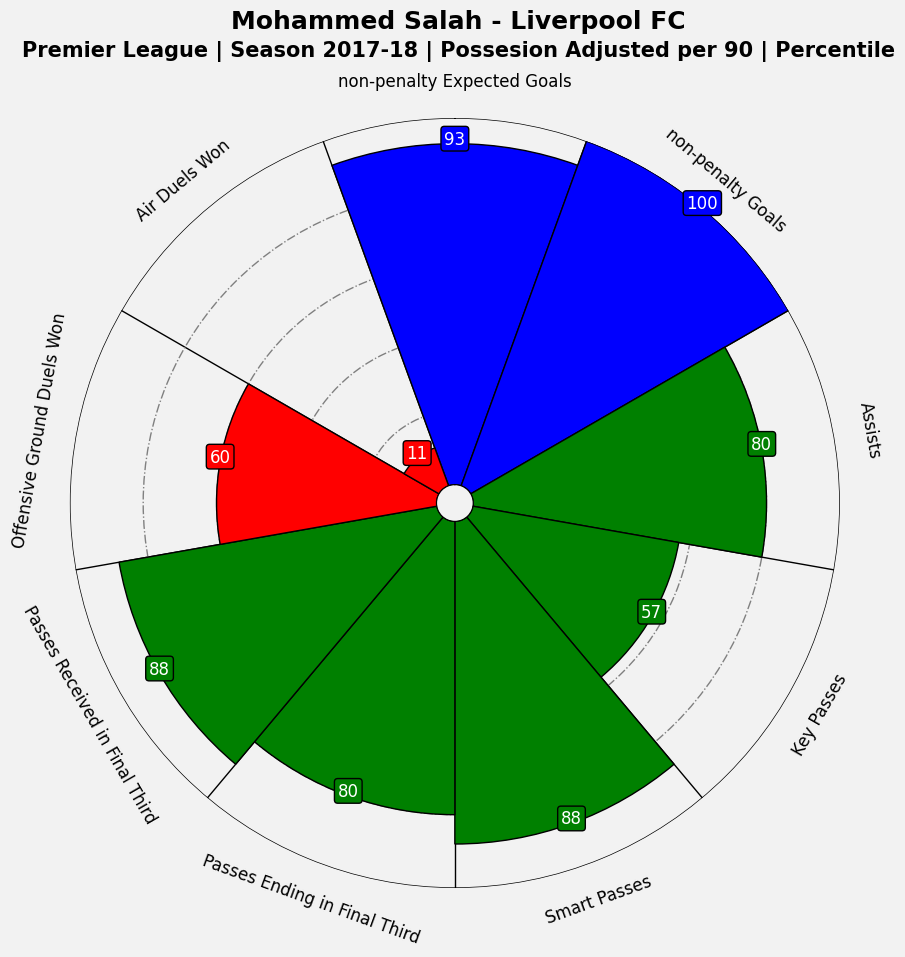

In [88]:
baker = PyPizza(params=names, straight_line_color="#000000", straight_line_lw=1, last_circle_lw=1, other_circle_lw=1, other_circle_ls="-.")
fig, ax = baker.make_pizza(
    percentiles
    , figsize=(15,10)
    , param_location=110
    , slice_colors=slice_colors
    , value_colors=text_colors
    , value_bck_colors=slice_colors
    , kwargs_slices=dict(facecolor="cornflowerblue", edgecolor="#000000", zorder=2, linewidth=1)
    , kwargs_params=dict(color="#000000", fontsize=12, va="center")
    , kwargs_values=dict(color="#000000", fontsize=12, zorder=3, bbox=dict(edgecolor="#000000", facecolor="cornflowerblue", boxstyle="round,pad=0.2", lw=1))    
)

fig.text(0.515, 0.97, "Mohammed Salah - Liverpool FC", size=18, ha="center", fontdict={"weight" : "bold"}, color="#000000")
fig.text(0.515, 0.942, "Premier League | Season 2017-18 | Possesion Adjusted per 90 | Percentile", size=15, ha="center", fontdict={"weight" : "bold"}, color="#000000")
plt.show()

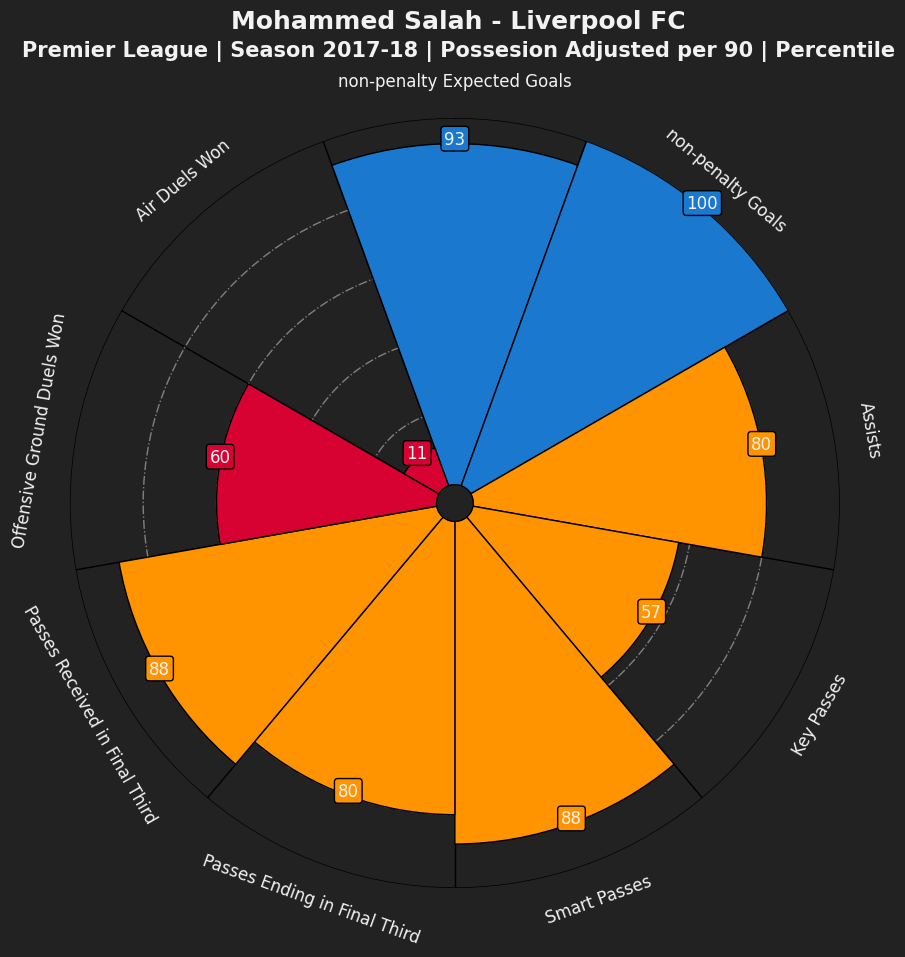

In [99]:
slice_colors = ["#1A78CF"] * 2 + ["#FF9300"] * 5 + ["#D70232"] * 2
text_colors = ["#F2F2F2"] * 9

baker = PyPizza(
    params=names
    , background_color="#222222"
    , straight_line_color="#000000"
    , straight_line_lw=1
    , last_circle_color="#000000"
    , last_circle_lw=1
    , other_circle_lw=1
    , other_circle_ls="-."
)


fig, ax = baker.make_pizza(
    percentiles
    , figsize=(15,10)
    , param_location=110
    , slice_colors=slice_colors
    , value_colors=text_colors
    , value_bck_colors=slice_colors
    , kwargs_slices=dict(facecolor="cornflowerblue", edgecolor="#000000", zorder=2, linewidth=1)
    , kwargs_params=dict(color="#F2F2F2", fontsize=12, va="center")
    , kwargs_values=dict(color="#F2F2F2", fontsize=12, zorder=3, bbox=dict(edgecolor="#000000", facecolor="cornflowerblue", boxstyle="round,pad=0.2", lw=1))    
)

fig.text(0.515, 0.97, "Mohammed Salah - Liverpool FC", size=18, ha="center", fontdict={"weight" : "bold"}, color="#F2F2F2")
fig.text(0.515, 0.942, "Premier League | Season 2017-18 | Possesion Adjusted per 90 | Percentile", size=15, ha="center", fontdict={"weight" : "bold"}, color="#F2F2F2")
plt.show()